# Metaheuristics Applied to Portuguese Relation Extraction

In [1]:
import os
import pickle

In [2]:
if not os.path.exists("workspace"):
    os.mkdir("workspace")

In [3]:
def save(data, file_name):
    with open(f"workspace/{file_name}.pkl", "wb") as file:
        pickle.dump(data, file)

In [4]:
def load(file_name):
    with open(f"workspace/{file_name}.pkl", "rb") as file:
        data = pickle.load(file)
    return data

## Load dataset

In [5]:
from source.datasets.dbpedia import DBpedia

In [6]:
dataset = DBpedia("data/DBpediaRelations-PT-0.2.txt")

In [7]:
print(f"number of samples: {len(dataset.data)}")

number of samples: 15392


In [8]:
print(f"number of positive samples: {sum(dataset.labels)}")

number of positive samples: 7696


In [9]:
dataset.data[0]

{'sentence': 'Albert Einstein nasceu na região alemã de Württemberg, na cidade de Ulm, numa família judaica.',
 'entity_1': 'Albert Einstein',
 'entity_2': 'Württemberg'}

## Create features

In [10]:
from source.features.tagger import Tagger

In [11]:
tagger = Tagger()

In [12]:
features_raw = tagger.tag(dataset.data)

100%|██████████| 15392/15392 [02:09<00:00, 119.06it/s]                                                                                                              


In [13]:
save(features_raw, "features_raw")

In [14]:
features_raw = load("features_raw")

In [15]:
# Remove incorrect samples

data, labels, features = [], [], []
for item, label, feature in zip(dataset.data, dataset.labels, features_raw):
    if feature:
        data.append(item)
        labels.append(label)
        features.append(feature)

In [16]:
data[0]

{'sentence': 'Albert Einstein nasceu na região alemã de Württemberg, na cidade de Ulm, numa família judaica.',
 'entity_1': 'Albert Einstein',
 'entity_2': 'Württemberg'}

In [17]:
features[0]

{'between': [100, 85, 92, 84, 85]}

In [18]:
tagger.convert_tags_to_strings(features[0])

{'between': ['VERB', 'ADP', 'NOUN', 'ADJ', 'ADP']}

## Select data

In [19]:
import random
from sklearn.model_selection import train_test_split

In [20]:
random.seed(42)

In [21]:
# Resample due to time limitations

N_SAMPLES = 2000

index = [i for i in range(0, len(features))]
index_sample = random.sample(index, N_SAMPLES)
features_sample = [features[i] for i in index_sample]
labels_sample = [labels[i] for i in index_sample]

In [22]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features_sample,
    labels_sample,
    train_size=0.7,
    random_state=42
)

In [23]:
print(f"number of train samples: {len(features_train)}")
print(f"number of test samples: {len(features_test)}")

number of train samples: 1400
number of test samples: 600


In [24]:
print(f"number of positive train samples: {sum(labels_train)}")
print(f"number of positive test samples: {sum(labels_test)}")

number of positive train samples: 677
number of positive test samples: 308


## Harmony Search

In [26]:
from source.metaheuristics.harmony_search import HarmonySearch

In [28]:
N_RUNS = 100
N_GENERATIONS = 500
N_SOLUTIONS = 50
N_PARAMETERS = 15
HMCR = 0.9
PAR = 0.5

In [29]:
hs = HarmonySearch(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_harmonies=N_SOLUTIONS,
    n_parameters=N_PARAMETERS,
    hmcr=HMCR,
    par=PAR
)

In [30]:
%%time

hs.fit(features_train, labels_train)

CPU times: total: 1.03 s
Wall time: 1h 52min 32s


In [31]:
hs.evaluate(features_test, labels_test)

{'f1': '0.67 ± 0.01886',
 'precision': '0.7607 ± 0.01972',
 'recall': '0.6001 ± 0.03525'}

In [32]:
save(hs, "harmony_search")

## Genetic Algorithm

In [33]:
from source.metaheuristics.genetic_algorithm import GeneticAlgorithm

In [34]:
N_ELITES = 10
MUTATION_RATE = 0.05

In [35]:
ga = GeneticAlgorithm(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_individuals=N_SOLUTIONS,
    n_parameters=N_PARAMETERS,
    n_elites=N_ELITES,
    mutation_rate=MUTATION_RATE
)

In [36]:
%%time

ga.fit(features_train, labels_train)

CPU times: total: 10 s
Wall time: 1h 28min 29s


In [37]:
ga.evaluate(features_test, labels_test)

{'f1': '0.6501 ± 0.02456',
 'precision': '0.788 ± 0.0365',
 'recall': '0.5559 ± 0.04203'}

In [38]:
save(ga, "genetic_algorithm")

## Simulated Annealing

In [39]:
from source.metaheuristics.simulated_annealing import SimulatedAnnealing

In [40]:
STEP_CHANCE = 0.3
INITITAL_TEMPERATURE = 100
TEMPERATURE_DECAY = 0.99

In [41]:
sa = SimulatedAnnealing(
    n_runs=N_RUNS,
    n_generations=N_GENERATIONS,
    n_individuals=N_SOLUTIONS,
    n_parameters=N_PARAMETERS,
    step_chance=STEP_CHANCE,
    initial_temperature=INITITAL_TEMPERATURE,
    temperature_decay=TEMPERATURE_DECAY
)

In [42]:
%%time

sa.fit(features_train, labels_train)

CPU times: total: 453 ms
Wall time: 1h 29min 30s


In [43]:
sa.evaluate(features_test, labels_test)

{'f1': '0.5858 ± 0.01614',
 'precision': '0.8181 ± 0.04937',
 'recall': '0.458 ± 0.02465'}

In [44]:
save(sa, "simulated_annealing")

## Statistical Tests

In [5]:
hs = load("harmony_search")

In [6]:
ga = load("genetic_algorithm")

In [7]:
sa = load("simulated_annealing")

### Histories Visualization

In [8]:
from source.statistics import convergence, distribution, diversity

In [9]:
histories = {
    "harmony search": hs.histories,
    "genetic algorithm": ga.histories,
    "simulated annealing": sa.histories
}

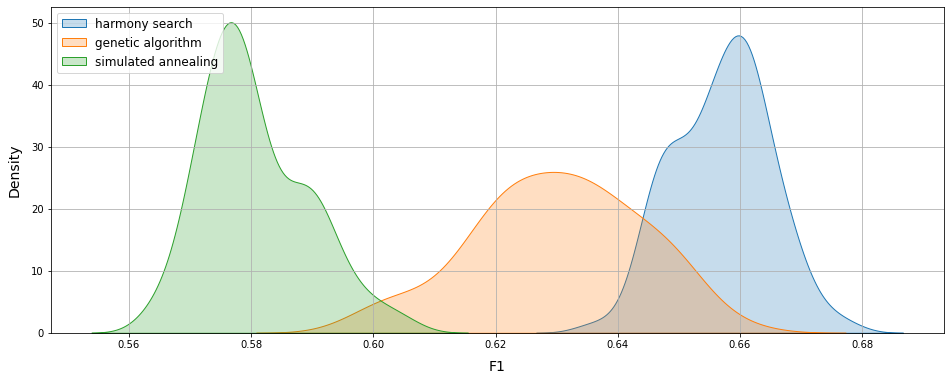

In [10]:
distribution.plot(histories)

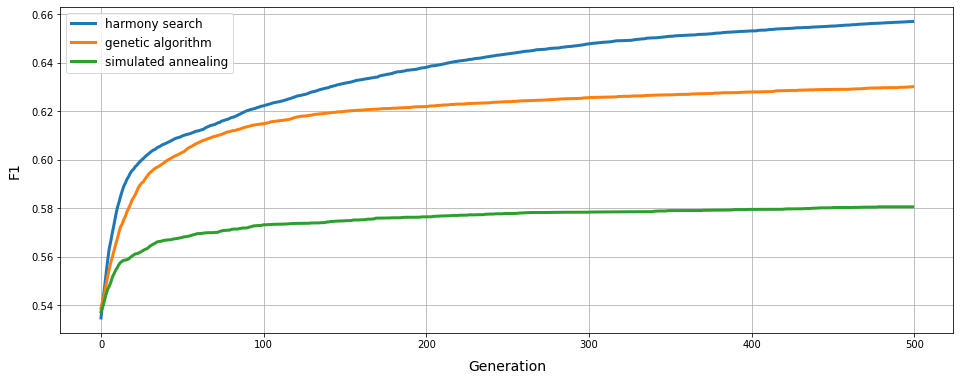

In [11]:
convergence.plot(histories)

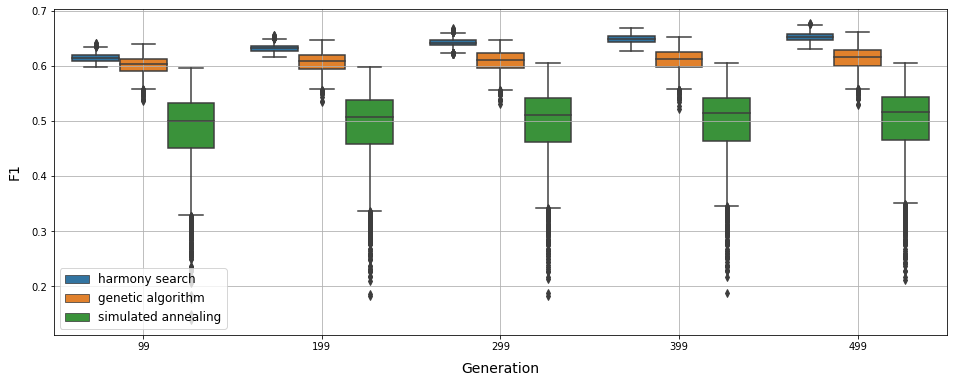

In [12]:
diversity.plot(histories)

### Shapito-Wilk Test

In [53]:
from source.statistics import shapiro_wilk

In [54]:
shapiro_wilk_test = {
    "harmony_search": shapiro_wilk.test(hs.histories),
    "genetic_algorithm": shapiro_wilk.test(ga.histories),
    "simulated_annealing": shapiro_wilk.test(sa.histories)
}

In [55]:
shapiro_wilk_test

{'harmony_search': (0.9904, 0.6953),
 'genetic_algorithm': (0.9887, 0.56),
 'simulated_annealing': (0.9602, 0.0041)}

### Student's T-test

In [56]:
from source.statistics import t_ind

In [57]:
t_test = {
    "hs - ga": t_ind.test(hs.histories, ga.histories),
    "hs - sa": t_ind.test(hs.histories, sa.histories),
    "ga - sa": t_ind.test(ga.histories, sa.histories)
}

In [58]:
t_test

{'hs - ga': (16.9928, 0.0),
 'hs - sa': (65.3267, 0.0),
 'ga - sa': (30.5137, 0.0)}